## Proposta:

O Classificador Naive-Bayes, o qual se baseia no uso do teorema de Bayes, é largamente utilizado em filtros anti-spam de e-mails. O classificador permite calcular qual a probabilidade de uma mensagem ser SPAM considerando as palavras em seu conteúdo e, de forma complementar, permite calcular a probabilidade de uma mensagem ser HAM (não-SPAM) dada as palavras descritas na mensagem.

O MVP (_minimum viable product_) do projeto consiste em um do classificador que "aprende" o que é uma mensagem SPAM considerando uma base de treinamento e posteriormente classifica mensagens como SPAM considerando uma base de testes (diferente da base de treinamento) e é capaz de calcular seu desempenho (comparando os resultados obtidos com a classificação real)

## Importando bibliotecas:

In [1]:
from collections import Counter as frequence_counter
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
import numpy as np
import os

## Filtrando banco de dados:

A filtragem do banco de dados foi feita com base nas seguintes simplificações:

* Converter todas as letras em minúsculas (evita de termos contagem de duas palavras iguais em significado mas escritas diferentemente. Ex.: "casa" e "Casa")

* Manter somente letras e números (elimina quaisquer outros caracteres tais como caracteres especiais, pontuações, emojis, etc)

Note que a filtragem foi feita antes da separação entre base de teste e base de treinamento por conveniência, uma vez que a filtragem teria que ser feita em ambas futuramente.

In [2]:
def database_cleaner(dataframe, column, export=False):
    
    # Alphanumerics symbols:
    alpha_numerics = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
                      'v', 'w', 'x', 'y', 'z', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', ' ']
    
    comments_list = []
    
    # Reading all comments in a dataframe's column:
    for comment in dataframe[column]:
        # Converting all letters to lowercase:
        comment = comment.lower()
        # Selecting only alphanumeric characters:
        char_list = [char for char in comment if char in alpha_numerics]
        # Generating clean comment:
        clean_comment = ''.join(char_list)
        
        #clean_comment_stem = [stemmer.stem(word) for word in clean_comment]
        
        #final_comment = '.'
        
        #comments_list.append(clean_comment_stemizados)
        comments_list.append(clean_comment)
        
    # Overwriting dataframe column with clean comments:
    dataframe[column] = comments_list
    
    # Exportation control:
    if export == False:
        return dataframe
    elif export == True:
        dataframe.to_excel('clean-spamham2019.xlsx')

In [3]:
database_cleaner(pd.read_excel('spamham2019.xlsx'), 'Email', export=True)

In [4]:
clean_df = pd.read_excel('clean-spamham2019.xlsx')
clean_df.head()

,Email,Class
0,go until jurong point crazy available only in ...,ham
1,ok lar joking wif u oni,ham
2,free entry in 2 a wkly comp to win fa cup fina...,spam
3,u dun say so early hor u c already then say,ham
4,nah i dont think he goes to usf he lives aroun...,ham


___

## Separação da base de dados:

A base de dados deve ser separada em duas partes, aleatoriamente, na seguinte proporção:     
* 75% dos dados para a Base de Treinamento
* 25% dos dados para a Base de Teste

In [5]:
def database_separator(database, test_size, display):
    # Database separation:
    training_data, testing_data = train_test_split(database, test_size=test_size)
    # Percentage variables:
    training_size = len(training_data)
    training_percent = round( (len(training_data)/len(database))*100, 3)
    testing_size = len(testing_data)
    testing_percent = round( (len(testing_data)/len(database))*100, 3)
    training_percent_spam = round(len(training_data.loc[training_data["Class"]=='spam'])/ len(clean_df)*100, 3)
    training_percent_spam_c = round(len(training_data.loc[training_data["Class"]=='ham'])/ len(clean_df)*100, 3)
    
    if display == True:
        # Shows the separation's absolute and relative values:
        print("Training Size: {} ({} %)\nTest Size: {} ({} %)\nTotal Size: {} (100 %)\n".format(training_size, training_percent, testing_size, testing_percent, len(database)))
        print("Training Partials: {} % SPAM + {} % HAM\n".format(training_percent_spam, training_percent_spam_c))
        
    return training_data, testing_data

___

## Classificador Naive-Bayes

Para compreender melhor o que está sendo feito nos cálculos a seguir, adote a seguinte convenção:

$$\begin{cases}
    message_{_{SPAM}}:\space quantidade\space de\space mensagens\space SPAM\\
    message_{_{HAM}}:\space quantidade\space de\space mensagens\space HAM\\
    message_{_{TOTAL}}:\space quantidade\space total\space de\space mensagens\\
    message: \space uma\space mensagem\space qualquer\\
    word_n:\space frequência\space de\space uma\space palavra\space qualquer\space de\space uma\space mensagem\\
    word_{SPAM}: quantidade\space de \space palavras \space SPAM\\
    word_{HAM}: quantidade\space de \space palavras \space HAM\\
    SPAM: \space ser\space classificado\space como\space SPAM\\
    HAM: \space ser classificado\space como \space HAM\\
\end{cases}$$

Sabendo que todas as mensagens são necessariamente e somente SPAM ou HAM,  podemos dizer que suas probabilidades são complementares. Portanto:

$$ message_{_{SPAM}} + message_{_{HAM}}\space=\space message_{_{TOTAL}}$$

$$P(message_{_{SPAM}}) + P(message_{_{HAM}})\space=\space 1\space=\space 100\%$$

Note que para que um modelo probabilístico funcione ele precisa ser alimentado com valores numéricos, entretanto estamos trabalhando puramente com texto. Para solucionar isso, usa-se algo relativamente simples: **frequência**.

E é a relação das frequências de palavras (considernado as mensagens SPAM, as mensagens HAM e todas as mensagens) que se baseia o classificador.

In [6]:
def training_classifier(training_data, display):
    
    spam_words = [word  for comment in (training_data[training_data['Class'] == 'spam']['Email']) for word in comment.split(' ') if word != ""]
    ham_words = [word for comment in (training_data[training_data['Class'] == 'ham']['Email']) for word in comment.split(' ') if word != ""]
    all_words = spam_words + ham_words

    spam_freq = frequence_counter(spam_words)
    ham_freq = frequence_counter(ham_words)
    all_freq = frequence_counter(all_words)
    
    if display == True:
        print("SPAM words: {}\nHAM words: {}\nAll words: {}\n".format(len(spam_words), len(ham_words), len(all_words)))
        print("Unique SPAM words: {}\nUnique HAM words: {}\nUnique all words: {}\n".format(len(spam_freq), len(ham_freq), len(all_freq)))
    
    return spam_freq, ham_freq, all_freq

Da primeira equação, podemos fazer a seguinte :

$$message_{_{SPAM}} + message_{_{HAM}} \space=\space message_{_{TOTAL}}\space\Rightarrow\space \frac{message_{_{SPAM}}}{message_{_{TOTAL}}} + \frac{message_{_{HAM}}}{message_{_{TOTAL}}}\space=\space\frac{message_{_{TOTAL}}}{message_{_{TOTAL}}}\space=\space 1$$

Comparando a equação obtida e a segunda equação:

$$\frac{message_{_{SPAM}}}{message_{_{TOTAL}}} + \frac{message_{_{HAM}}}{message_{_{TOTAL}}}\space=\space1$$

$$P(message_{_{SPAM}}) + P(message_{_{HAM}})\space=\space 1$$

Logo:

$$P(message_{_{SPAM}})=\frac{message_{_{SPAM}}}{message_{_{TOTAL}}}$$

$$P(message_{_{HAM}})=\frac{message_{_{HAM}}}{message_{_{TOTAl}}}$$

In [7]:
def P_SPAM(spam_freq, all_freq):
    return len(spam_freq.keys())/len(all_freq.keys())

def P_HAM(ham_freq, all_freq):
    return len(ham_freq.keys())/len(all_freq.keys())

Todo o cálculo por trás do classificador se resume basicamente a duas partes, o Teorema de Bayes e a suposição "ingênua" (ou em inglês, "*naive*") sobre as palavras de uma frase.

Como a suposição "*naive*" é necessária ao teorema, faz sentido analisá-la primeiro e depois analisar o teorema.

A suposição "*naive*" é a seguinte:
> Assumir que todas as palavras de uma mesma mensagem sejam independentes entre si.

Isso significa que a mensagem nada mais é do que um conjunto de palavras (implicando que a ordem dessas palavras é irrelevante, o que é "ingênuo" uma vez que sabemos que a ordem das palavras em uma frase têm importância, entretanto isso mantém a simplicidade do classificador e em termos de resultado é eficiente), e portanto a probabilidade de uma mensagem é a probabilidade de cada uma de suas palavras multiplicadas ocorrerem $(palavra_1 \space e\space palavra_2 \space e \space \cdots palavra_n)$. 

Portanto, em termos matemáticos podemos dizer que:

$$P(message)\space=\space\prod_{n=word} P(word_n)$$

Assim sendo podemos reescrever as equações obtidas anteriormente da seguinte forma:

$$P(message|SPAM)\space=\space\prod_{n=word} P(word_n|SPAM)$$

$$P(message|HAM)\space=\space\prod_{n=word} P(word_n|HAM)$$

Sabemos que $P(word_n|SPAM)$ nada mais é do que a frequência de uma palavra com relação ao total de palavras em SPAM, consequentemente $P(word_n|HAM)$ é a frequência de uma palavra com relação ao total de palavras HAM. Logo:

$$P(message|SPAM)\space=\space\prod_{n=word} P(word|SPAM) \space=\space\sum_{n=word} \frac{word_n}{word_{SPAM}}$$

$$P(message|HAM)\space=\space\prod_{n=word} P(word|HAM) \space=\space\sum_{n=word} \frac{word_n}{word_{HAM}}$$


In [8]:
def P_word_SPAM(word, spam_freq, all_freq):
    if word in spam_freq.keys():
        return (spam_freq[word] + 1)/(len(spam_freq.keys()) + len(spam_freq.keys()))
    else:
        return (1)/(len(spam_freq.keys()) + len(spam_freq.keys()))

def P_word_HAM(word, ham_freq, all_freq):
    if word in ham_freq.keys():
        return (ham_freq[word] + 1)/(len(ham_freq.keys()) + len(all_freq.keys()))
    else:
        return (1)/(len(ham_freq.keys()) + len(all_freq.keys()))
    
def P_message_SPAM(message, spam_freq, all_freq):
    return np.prod(np.array([P_word_SPAM(word, spam_freq, all_freq) for word in message.split(' ') if word != ""]))
    
def P_message_HAM(message, ham_freq, all_freq):
    return np.prod(np.array([P_word_HAM(word, ham_freq, all_freq) for word in message.split(' ') if word != ""]))

Uma vez que já se tem calculado $P(message|SPAM)$ e $P(message|HAM)$, podemos partir para a segunda parte: o Teorema de Bayes.

Segundo o Teorema de Bayes, temos que:

$$P(A|B)\space=\space\frac{P(B|A)\cdot P(A)}{P(B)}$$

Trazendo para o contexto do problema, queremos saber a probabilidade de ser SPAM ou HAM dado uma certa mensagem, ou seja, queremos saber $P(SPAM|message)$ e $P(HAM|message)$. 

Usando o Teorema de Bayes e assumnido que $A:SPAM\space ou \space HAM$ e $B:message$, temos que:

$$P(SPAM|message)\space=\space\frac{P(message|SPAM)\cdot P(SPAM)}{P(message)}$$

$$P(HAM|message)\space=\space\frac{P(message|HAM)\cdot P(HAM)}{P(message)}$$

Considerando que o classificação consiste em saber qual probabilidade é maior (de ser SPAM ou HAM), basta dividir ambas as equações:

$$Classification\space=\space\frac{P(SPAM|message)}{P(HAM|message)}\space=\space \frac{\frac{P(message|SPAM)\cdot P(SPAM)}{P(message)}}{\frac{P(message|HAM)\cdot P(HAM)}{P(message)}}\space=\space \frac{P(message|SPAM)\cdot P(SPAM)}{P(message|HAM)\cdot P(HAM)}$$

Com isso, eliminamos a variável $P(message)$ e, além disso, torna-se muito mais fácil a classificação, basta comparar se o resultado é maior ou menor que 0.

Note quese a probabilidade de ser SPAM é maior do que ser HAM, ou seja, se $P(message|SPAM) > P(message|HAM)$ o resultado será maior do que 0; caso contrário, ou seja, se $P(message|SPAM) < P(message|HAM)$ o resultado será menor do que 0.

In [9]:
def classification(message, spam_freq, ham_freq, all_freq):
    P_SPAM_message = P_message_SPAM(message, spam_freq, all_freq)*P_SPAM(spam_freq, all_freq)
    P_HAM_message = P_message_HAM(message, ham_freq, all_freq)*P_HAM(ham_freq, all_freq)
    if P_SPAM_message > P_HAM_message:
        return "spam"
    elif P_SPAM_message < P_HAM_message:
        return "ham"
    else:
        return "unknown"

Sabendo classificar uma mensagem em SPAM ou HAM, basta aplicar o mesmo método para todas as mensagens do *database* de testes.

In [10]:
def test_iteration(test_df, spam_freq, ham_freq, all_freq):
    return [classification(comment, spam_freq, ham_freq, all_freq) for comment in test_df['Email']]  

Para classificar a qualidade do classificador, deve-se observar os seguintes marcadores de qualidade:

* % de falsos positivos (mensagens marcadas como SPAM mas não são SPAM)
* % de positivos verdadeiros (mensagens marcadas como SPAM e são SPAM)
* % de falsos negativos (mensagens marcadas como não SPAM mas são SPAM)
* % de negativos verdadeiros (mensagens marcadas como não SPAM e não são SPAM)

In [11]:
def quality_control(testing_df, spam_freq, ham_freq, all_freq, display):
    
    false_pos = 0
    true_pos = 0
    false_neg = 0
    true_neg = 0
    error_detector = 0
    total = testing_df.shape[0]
    
    for test_result, real_result in zip(test_iteration(testing_df, spam_freq, ham_freq, all_freq), testing_df['Class']):
        if (test_result == 'spam') and (real_result == 'ham'):
            false_pos += 1
        elif (test_result == 'spam') and (real_result == 'spam'):
            true_pos += 1
        elif (test_result == 'ham') and (real_result == 'spam'):
            false_neg += 1
        elif (test_result == 'ham') and (real_result == 'ham'):
            true_neg += 1
        else:
            error_detector += 1
    
    if display == True:
        print('False Positives: {}\nTrue Positives: {}\nFalse Negatives: {}\nTrue Negatives:{}\n'.format(false_pos, true_pos, false_neg, true_neg))
        print('Efficiency: {} %'.format(round(((true_pos + true_neg)/(true_pos + true_neg + false_pos + false_neg))*100, 2)))
        if error_detector != 0:
            print('{} errors detected!'.format(error_detector))
    return pd.DataFrame([[true_pos, false_pos], [false_neg, true_neg], [error_detector]], index=['spam', 'ham', 'error'], columns=['spam', 'ham'])

Com isso o Classificador tem tudo o que precisa para funcionar, lembrando que a ordem de execução é a seguinte:
* Separar as bases de treinamento e teste
* Treinar o Classificador com a *database* de treinamento
* Testar o Classificador com a *database* de testes, comparando os resultados

In [12]:
def naive_bayes_classifier(database, test_size, display=True):
    # Splits in training and testing databases:
    training_data, testing_data = database_separator(pd.read_excel(database), test_size=test_size, display=display)
    # Creating dictionaries with words frequencies:
    spam_freq, ham_freq, all_freq = training_classifier(training_data, display=display)
    # Classifying comments and generating results:
    return quality_control(testing_data, spam_freq, ham_freq, all_freq, display=display)

In [13]:
naive_bayes_classifier('clean-spamham2019.xlsx', 0.25)

Training Size: 4179 (75.0 %)
Test Size: 1393 (25.0 %)
Total Size: 5572 (100 %)

Training Partials: 10.212 % SPAM + 64.788 % HAM

SPAM words: 13245
HAM words: 50611
All words: 63856

Unique SPAM words: 2582
Unique HAM words: 6413
Unique all words: 8102

False Positives: 28
True Positives: 167
False Negatives: 11
True Negatives:1187

Efficiency: 97.2 %


,spam,ham
spam,167,28.0
ham,11,1187.0
error,0,NaN


___

## Qualidade do Classificador alternando a base de treinamento

Ao fazermos a separação dos dados em *databases* de teste e treinamento, estamos representando uma entre infinitas situações de separação possíveis e, ao usar o Classificador estamos obtendo um entre infinitos resultados possíveis.

Entenda que os resultados obtidos dependem dessa separação, e por isso, existe a possibiliadde de serem bons somente em algumas situações.

Para provar que o Classificador é eficiente  não só em certas situações, mas sim para quaisquer situações será feito um teste de qualidade que se resume em rodar várias vezes a separação e o classificador, para comprovar que ele é realmente eficiente.

A primeira coisa necessária é ser capaz de extrair os resultados gerados:

In [14]:
def extracting_results(dataframe):
    true_pos = dataframe.iloc[0, 0]
    false_pos = dataframe.iloc[0, 1]
    false_neg = dataframe.iloc[1, 0]
    true_neg = dataframe.iloc[1, 1]
    errors = dataframe.iloc[2, 0]
    
    efficiency = ((true_pos + true_neg)/(true_pos + false_pos + false_neg + true_neg))*100
    
    return [true_pos, false_pos, false_neg, true_neg, errors, efficiency]

Em seguida, a separação em *databases* de teste e treinamento será feitas repetidas vezes e em cada vez o Classificador será executado, salvando os resultados obtidos em cada uma das separações.

In [15]:
def overcycle(cycles=10000, step=100, export=False, display=True):
    result_storage = []
    for cycle in range(1, cycles + 1):
        result_storage.append(extracting_results(naive_bayes_classifier('clean-spamham2019.xlsx', 0.25, display=False)))
        if display == True:
            if (cycle % round(cycles/step)) == 0:
                print("Processing...({}/{})".format(cycle, cycles))
        
    result_storage_df = pd.DataFrame(result_storage, columns=['True Pos', 'False Pos', 'False Neg', 'True Neg', 'Errors', 'Efficiency'])
    print("Data compilation successful")
    
    if export == True:   
        result_storage_df.to_excel('results_log.xlsx')
        print("Report exported")
    if export == False:
        return result_storage_df

In [16]:
overcycle(10000, step=100, export=True)

Processing...(100/10000)
Processing...(200/10000)
Processing...(300/10000)
Processing...(400/10000)
Processing...(500/10000)
Processing...(600/10000)
Processing...(700/10000)
Processing...(800/10000)
Processing...(900/10000)
Processing...(1000/10000)
Processing...(1100/10000)
Processing...(1200/10000)
Processing...(1300/10000)
Processing...(1400/10000)
Processing...(1500/10000)
Processing...(1600/10000)
Processing...(1700/10000)
Processing...(1800/10000)
Processing...(1900/10000)
Processing...(2000/10000)
Processing...(2100/10000)
Processing...(2200/10000)
Processing...(2300/10000)
Processing...(2400/10000)
Processing...(2500/10000)
Processing...(2600/10000)
Processing...(2700/10000)
Processing...(2800/10000)
Processing...(2900/10000)
Processing...(3000/10000)
Processing...(3100/10000)
Processing...(3200/10000)
Processing...(3300/10000)
Processing...(3400/10000)
Processing...(3500/10000)
Processing...(3600/10000)
Processing...(3700/10000)
Processing...(3800/10000)
Processing...(3900/10

___

## Análise dos Resultados

In [9]:
results_log = pd.read_excel('results_log.xlsx')
results_log.head()

,True Pos,False Pos,False Neg,True Neg,Errors,Efficiency
0,181,31,10,1169,2,97.052480
1,170,29,10,1184,0,97.200287
2,171,30,8,1183,1,97.270115
3,164,44,9,1176,0,96.195262
4,176,46,12,1159,0,95.836324


Com os resultados das diversas iterações, será criado um histograma com os percentuais de acerto:

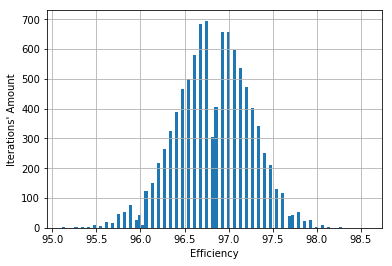

In [28]:
plt.hist(results_log['Efficiency'], bins=100)
plt.xlabel('Efficiency')
plt.ylabel("Density")
plt.grid()
plt.show()

Com os dados do histograma podemos dizer com mais clareza a qualidade do Classificador, uma vez que temos dados suficientes para gerar uma análise.

Seus resultados variam entre $95\%$ e $98,5\%$, aproximadamente.

In [10]:
print('Max Efficiency: {} %\nMin Efficiency: {} %\nMean Efficiency: {} %'.format(round(max(results_log['Efficiency']), 4), round(min(results_log['Efficiency']), 4), round(results_log['Efficiency'].mean(), 4)))

Max Efficiency: 98.5642 %
Min Efficiency: 95.1149 %
Mean Efficiency: 96.828 %


Em média, o programa classifica quase $97\%$ das mensagens corretamente.

Outro dado interessante a ser observado é a quantidade de erros gerados pelo programa. Um erro é gerado quando o classificador não sabe se uma determinada mensagem é SPAM ou HAM e o classifica como *"unknown"* Observe com atenção o código implementado na função `classification`:

>`if P_SPAM_message > P_HAM_message:
    return "spam"
elif P_SPAM_message < P_HAM_message:
    return "ham"
else:
    return "unknown"`
    
Segundo o código, a mensagem é classificada como *"unknown"* quando $P(message|SPAM)$ não é nem maior nem menor do que $P(message|HAM)$, ou seja:

$$P(message|SPAM)\nless P(message|HAM)$$
$$P(message|SPAM)\ngtr P(message|HAM)$$

Portanto, para que ambas as sentenças sejam verdadeiras, a única solução possível é que ambas probabilidades sejam iguais:

$$P(message|SPAM)=P(message|HAM)$$

A maior suspeita para gerar tal resultado são mensagens longas. Mensagens longas tem muitas palavras o que acarreta em muitos termos no multiplicatório quando é calculado $P(message|SPAM)$ e $P(message|HAM)$ onde cada um desses termos é menor do que 1, já que:
$$P(message_{_{SPAM}})=\frac{message_{_{SPAM}}}{message_{_{TOTAL}}}$$

Onde a sentença $message_{_{SPAM}} > message_{_{TOTAL}}$ é sempre verdadeira, já que $message_{_{SPAM}} \subset message_{_{TOTAL}}$ (lê-se: o conjunto de mensagens classificadas como SPAM é subconjunto do conjunto de mensagens totais). O mesmo se aplicada para $P(message_{_{SPAM}})$.

Sendo assim, ao realizar o multiplicatório com tantas probabilidades menores do que 1, o resultado obtido é compreendido como 0 pelo computador em ambas as probabilidades, chegando na seguinte conclusão:


$$P(message|SPAM)\space=\space0\space=\space P(message|HAM)$$
$$\Rightarrow\space message_{unknown}$$

Após compreender como os erros são gerados, é necessário analisar com que frequência eles aparecem. Entenda que presença de erros pode ser um problema dependendo da quantidade.

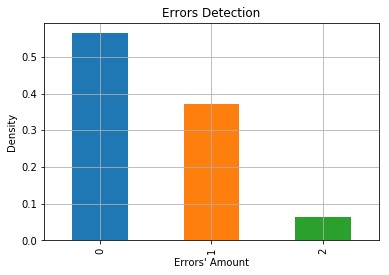

0 errors: 56.4 %
1 errors: 37.24 %
2 errors: 6.36 %

Mean Errors: 0.4996


In [43]:
results_log['Errors'].value_counts(normalize=True).plot(kind='bar')
plt.title("Errors Detection")
plt.xlabel("Errors' Amount" )
plt.ylabel('Density')
plt.grid()
plt.show()

errors_list = [print('{} errors: {} %'.format(x, round(y, 4))) for x, y in zip(results_log['Errors'].value_counts(normalize=True).keys(), results_log['Errors'].value_counts(normalize=True).values*100)]

print('\nMean Errors: {}'.format(results_log['Errors'].mean()))

Pelos resultados obtidos vemos que o não houve mais do que 2 erros em qualquer uma das 10000 situações criadas, sendo que dessas situações mais da metade ($56,4\%$) não apresentaram erro nenhum.

Considerando que no total há aproximadamente 1400 mensagens na base de testes, é aceitável que 2 delas sejam consideradas como erros.

## Conclusão

Pode-se concluir que o Classificador Naive-Bayes foi bem sucedido, uma vez que seus resultados se mostraram satisfatórios.
Ainda sim, algumas melhorias podem ser feitas, tais como:
* Unificar radicais (Ex.: comprar,comprei e compras se tornariam um radical só: compr)
* Impedir valores de probabilidades muito próximos de 0 (Ex.: dividir mensagens grandes em sub-mensagens, calcular probabilidades de SPAM e HAM para essas sub-mensagens, multiplicá-las por um valor $x<1$ e depois multiplicá-las entre si, gerando a probabilidade da mensagem original)